# Multi-Class Prediction of Cirrhosis Outcomes


[Kaggle Link](https://www.kaggle.com/competitions/playground-series-s3e26/overview)

# Problem Statement

Devise a multi class classification algorithm to predict the the outcomes of patients with cirrhosis


Submissions are evaluated using the **multi-class logarithmic loss**.
Each id in the test set had a single true class label, Status. 
For each id, we must submit a set of predicted probabilities for each of the three possible outcomes, e.g., Status_C, Status_CL, and Status_D.

# 1. Importing Libraries

In [1]:
import pandas as pd

import os
import numpy as np
from sklearn import preprocessing
import optuna
from tqdm import tqdm
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,log_loss
from lightgbm import LGBMClassifier,early_stopping
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from fasteda import fast_eda

# 2. Data Understanding

In [2]:
data_train = pd.read_csv("./data/train.csv")
data_test = pd.read_csv("./data/test.csv")
original = pd.read_csv("./data/cirrhosis.csv")

random_seed=42

In [3]:
data_train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [4]:
data_train.shape

(7905, 20)

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

In [6]:
data_train.isnull().any()

id               False
N_Days           False
Drug             False
Age              False
Sex              False
Ascites          False
Hepatomegaly     False
Spiders          False
Edema            False
Bilirubin        False
Cholesterol      False
Albumin          False
Copper           False
Alk_Phos         False
SGOT             False
Tryglicerides    False
Platelets        False
Prothrombin      False
Stage            False
Status           False
dtype: bool

In [7]:
data_train.columns

Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status'],
      dtype='object')

In [8]:
# dropping the id column as it is unique for each row
data_train = data_train.drop('id', axis = 1)
data_test = data_test.drop('id', axis = 1)

In [9]:
TARGET='Status'
FEATURES = [col for col in data_train.columns if col not in [TARGET]]
print("Target column ",TARGET)
print("Features Column ",FEATURES)
data_train['Status'].value_counts()

Target column  Status
Features Column  ['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']


Status
C     4965
D     2665
CL     275
Name: count, dtype: int64

In [10]:
categorical_columns = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema','Stage']
continous_columns = list(set(data_train.columns.tolist())-set(categorical_columns)-set(['Status','id']))

print("Categorical columns ",categorical_columns)
print("Continous columns {0}\n".format(continous_columns))


for column_name in categorical_columns:
    print("For column name ",column_name)
    print("Number of unique values ",len(data_train[column_name].unique().tolist()))
    print("Unique values Distribution \n",data_train[column_name].value_counts())
    print()

Categorical columns  ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']
Continous columns ['Alk_Phos', 'Prothrombin', 'N_Days', 'Copper', 'Age', 'SGOT', 'Cholesterol', 'Albumin', 'Bilirubin', 'Platelets', 'Tryglicerides']

For column name  Drug
Number of unique values  2
Unique values Distribution 
 Drug
Placebo            4010
D-penicillamine    3895
Name: count, dtype: int64

For column name  Sex
Number of unique values  2
Unique values Distribution 
 Sex
F    7336
M     569
Name: count, dtype: int64

For column name  Ascites
Number of unique values  2
Unique values Distribution 
 Ascites
N    7525
Y     380
Name: count, dtype: int64

For column name  Hepatomegaly
Number of unique values  2
Unique values Distribution 
 Hepatomegaly
Y    4042
N    3863
Name: count, dtype: int64

For column name  Spiders
Number of unique values  2
Unique values Distribution 
 Spiders
N    5966
Y    1939
Name: count, dtype: int64

For column name  Edema
Number of unique values  3
Un

## Observations

1. The have no missing values in the datasets.
2. There have no duplicates value in the dataset.
3. The target **'Status'** Comes with three unique values(C, CL, D)
4. We have 7 Categorical features and 11 Continous features

# 3. Extrapolatory Data Analysis

In [11]:
def preprocess(df):
    df["Drug"] = df["Drug"].map({"Placebo": 0, "D-penicillamine": 1})
    df["Sex"] = df["Sex"].map({"M": 0, "F": 1})
    for col in ["Ascites", "Hepatomegaly", "Spiders"]:
        df[col] = df[col].map({"N": 0, "Y": 1})
    df["Edema"] = df["Edema"].map({"N": 0, "S": 1, "Y": 1})  
    return df

def scale_data(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[FEATURES])
    df[FEATURES] = scaled_data
    return df


for df in [data_train, data_test,original]:
    df = preprocess(df)

data_train[TARGET] = data_train[TARGET].map({"D": 0, "CL": 1, "C": 2})
original[TARGET] = original[TARGET].map({"D": 0, "CL": 1, "C": 2})


DataFrame Head:


,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,1,21532,0,0,0,0,0,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,0
1,2574,0,19237,1,0,0,0,0,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,2
2,3428,0,13727,1,0,1,1,1,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,0


DataFrame Tail:


,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
7902,1576,1,25873,1,0,0,1,1,2.0,225.0,3.19,51.0,933.0,69.75,62.0,200.0,12.7,2.0,0
7903,3584,1,22960,0,0,1,0,0,0.7,248.0,2.75,32.0,1003.0,57.35,118.0,221.0,10.6,4.0,0
7904,1978,1,19237,1,0,0,0,0,0.7,256.0,3.23,22.0,645.0,74.40,85.0,336.0,10.3,3.0,2


----------------------------------------------------------------------------------------------------
Missing values:


,0


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(7905, 19)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   int64  
 2   Age            7905 non-null   int64  
 3   Sex            7905 non-null   int64  
 4   Ascites        7905 non-null   int64  
 5   Hepatomegaly   7905 non-null   int64  
 6   Spiders        7905 non-null   int64  
 7   Edema          7905 non-null   int64  
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 

/Users/abhjha8/kaggle_competitions/venv/lib/python3.10/site-packages/fasteda/__init__.py:86: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  full_info.iloc[:,:-2] = full_info.iloc[:,:-2].applymap(lambda x: format(x, '.3f') \
/Users/abhjha8/kaggle_competitions/venv/lib/python3.10/site-packages/fasteda/__init__.py:91: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(full_info.style.background_gradient(cmap = "Spectral", subset = full_info.columns[:-2])


,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
N_Days,7905,2030.173,1831,1094.234,41,1230,1831,2689,4795,0.448575,-0.494464
Drug,7905,0.493,0,0.5,0,0,0,1,1,0.029099,-1.999153
Age,7905,18373.146,18713,3679.959,9598,15574,18713,20684,28650,0.084075,-0.497827
Sex,7905,0.928,1,0.258,0,1,1,1,1,-3.312153,8.970357
Ascites,7905,0.048,0,0.214,0,0,0,0,1,4.225296,15.853130
Hepatomegaly,7905,0.511,1,0.5,0,0,1,1,1,-0.045299,-1.997948
Spiders,7905,0.245,0,0.43,0,0,0,0,1,1.183998,-0.598148
Edema,7905,0.094,0,0.292,0,0,0,0,1,2.780089,5.728896
Bilirubin,7905,2.594,1.1,3.813,0.3,0.7,1.1,3,28,3.339062,12.899902
Cholesterol,7905,350.562,298,195.379,120,248,298,390,1775,3.678959,18.150082


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



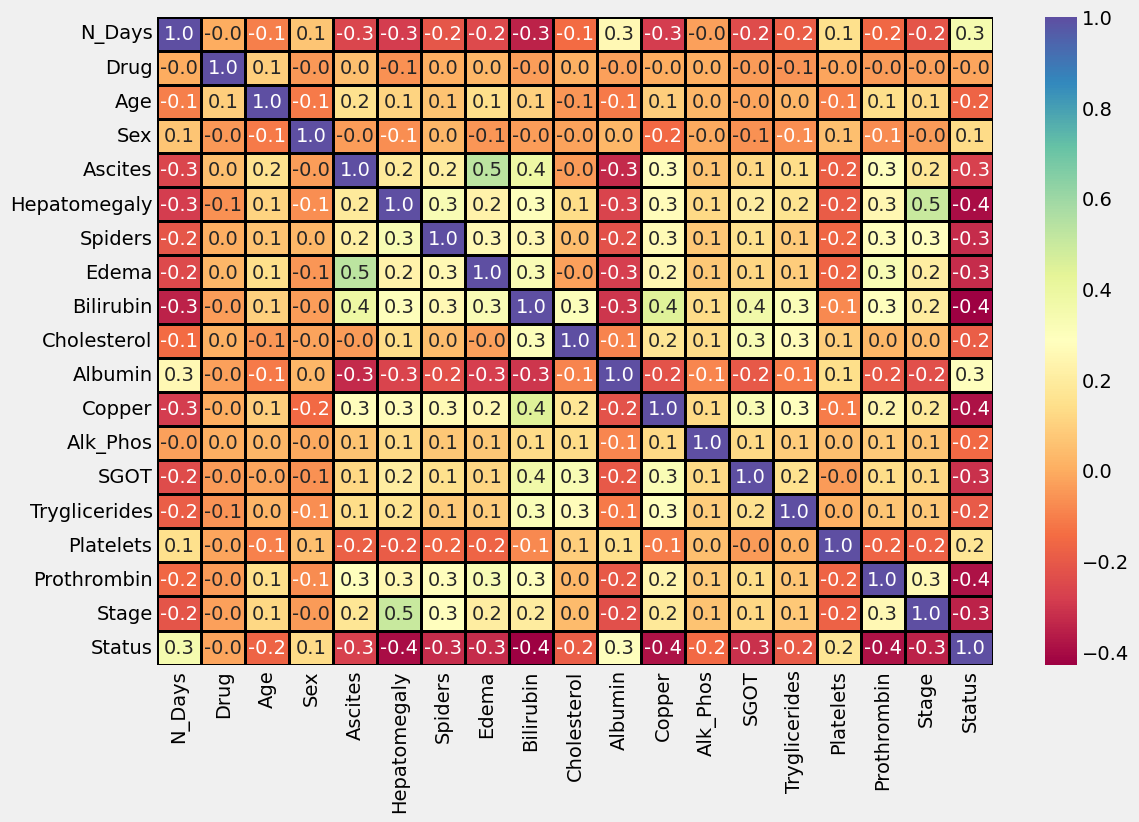

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



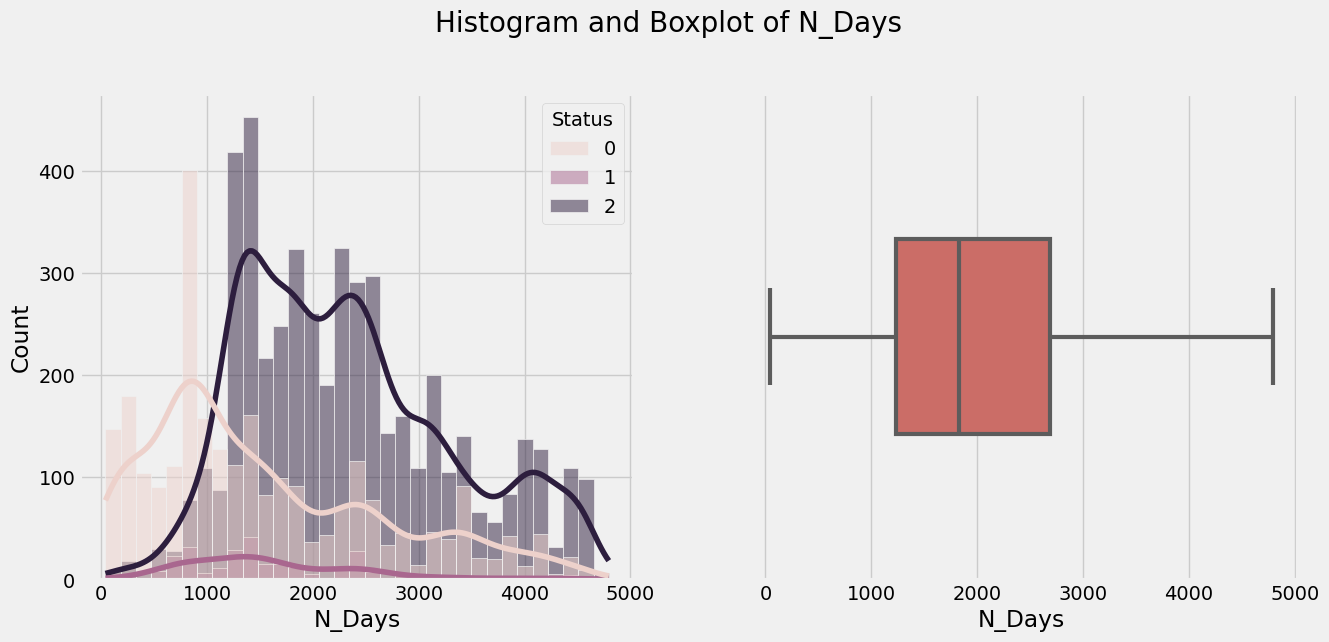

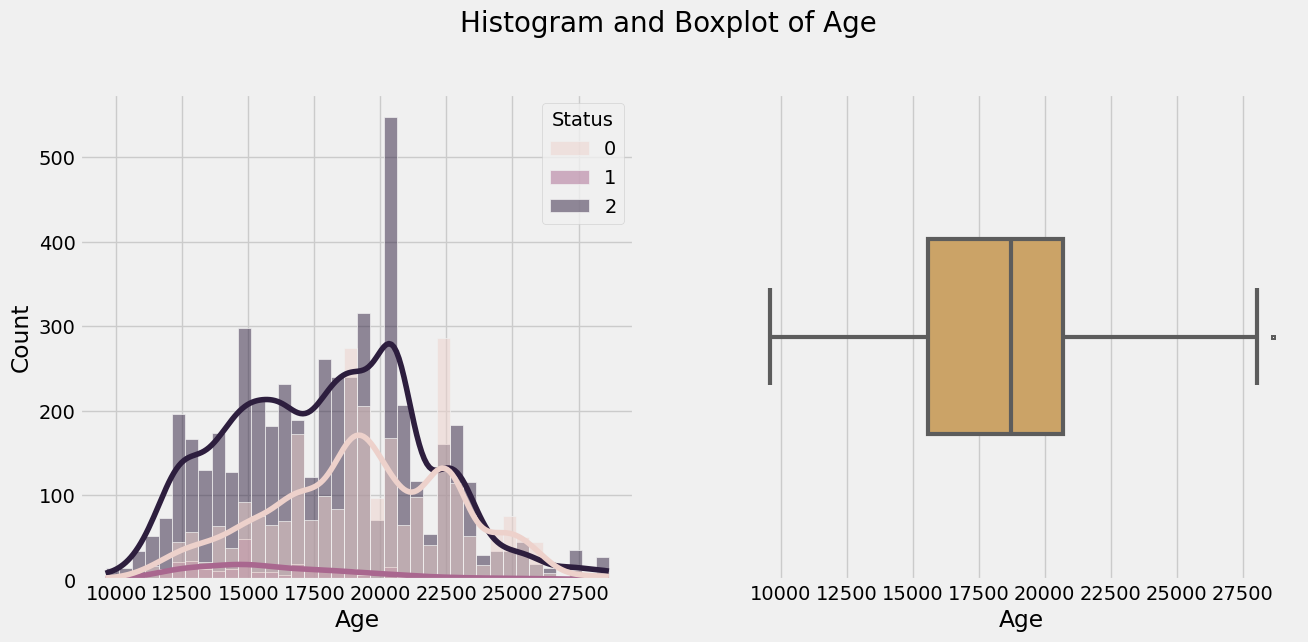

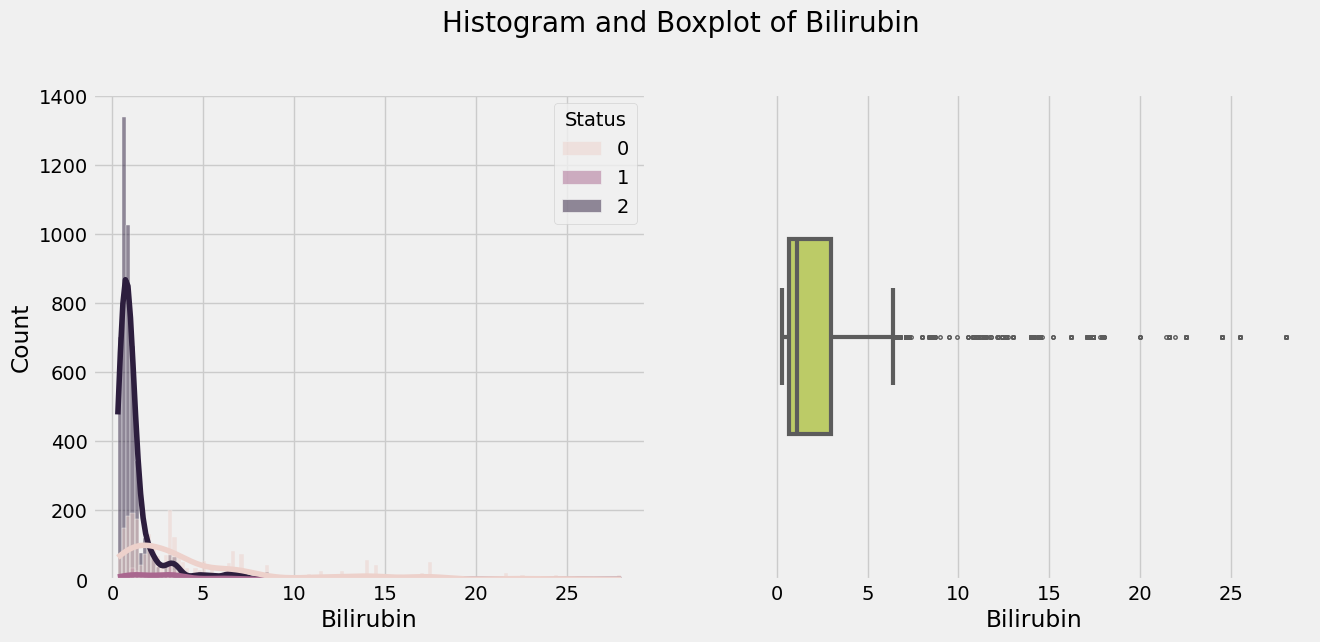

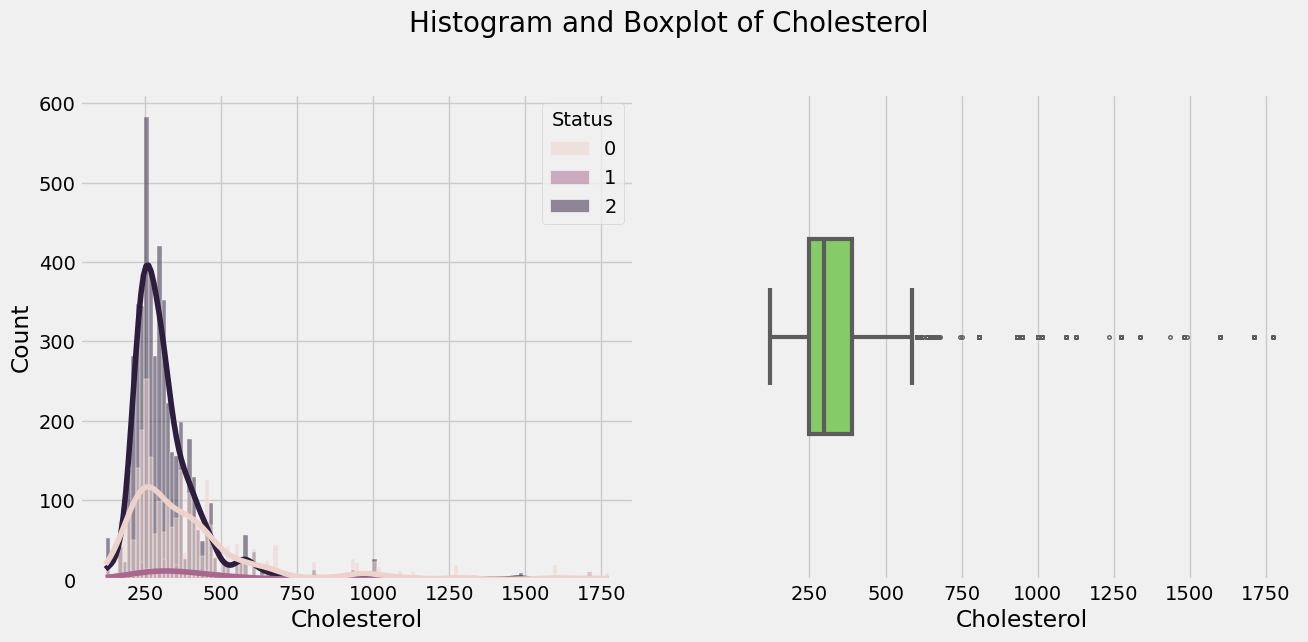

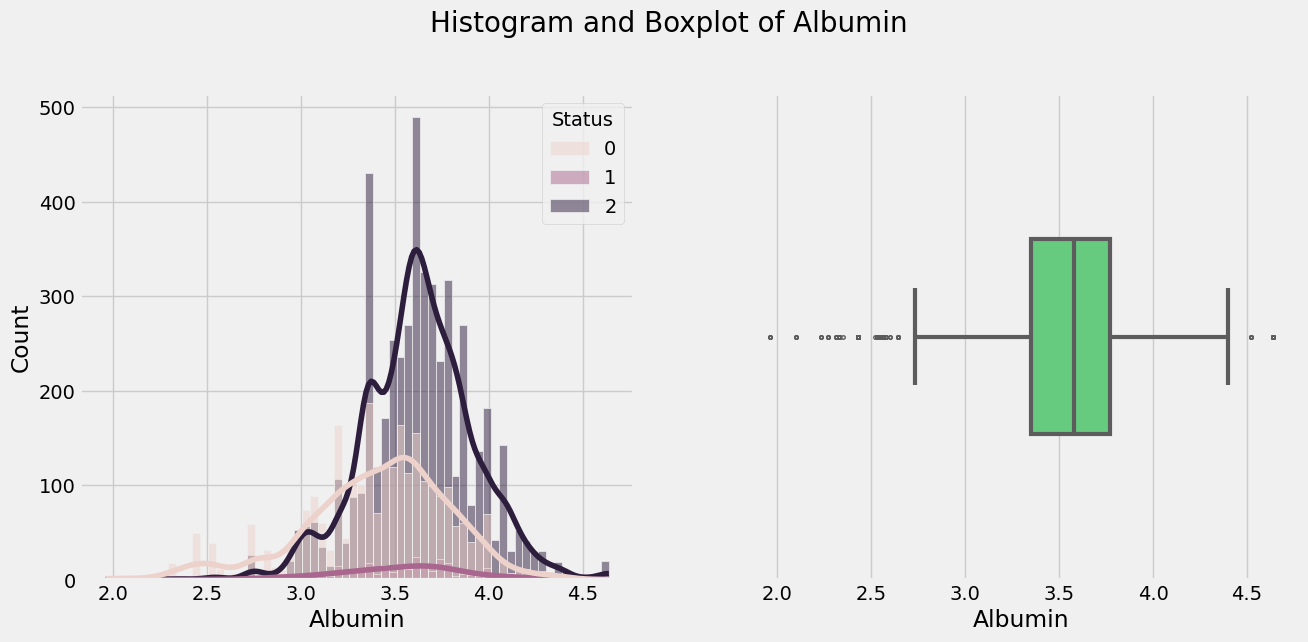

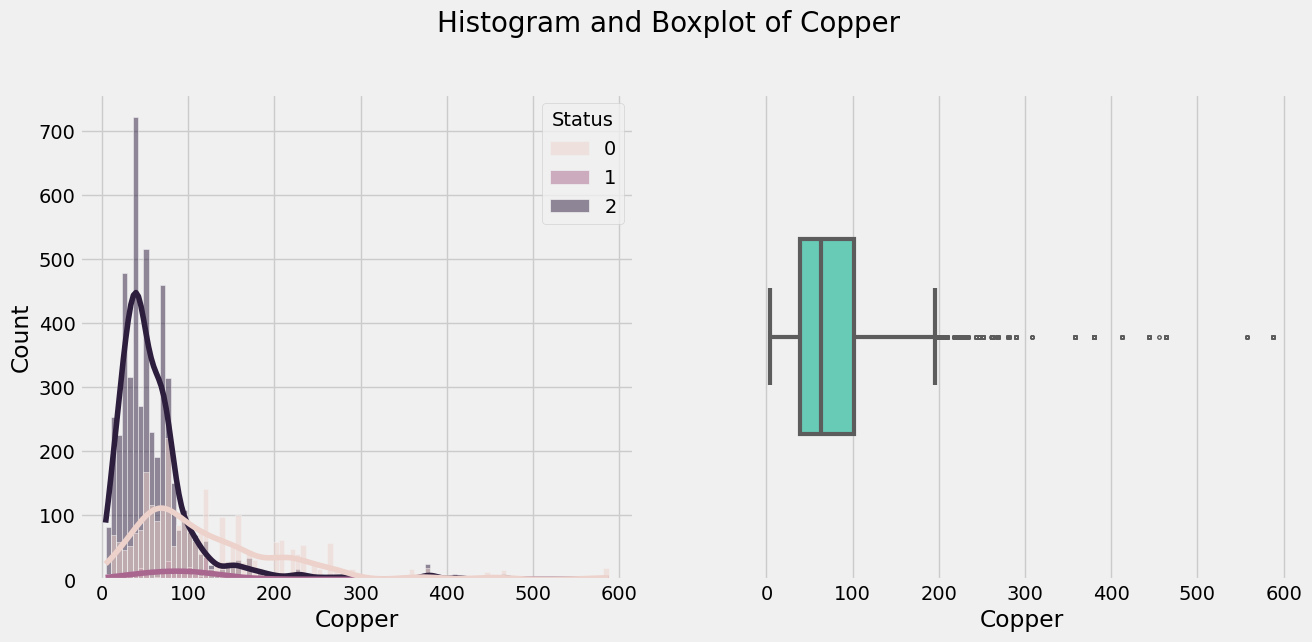

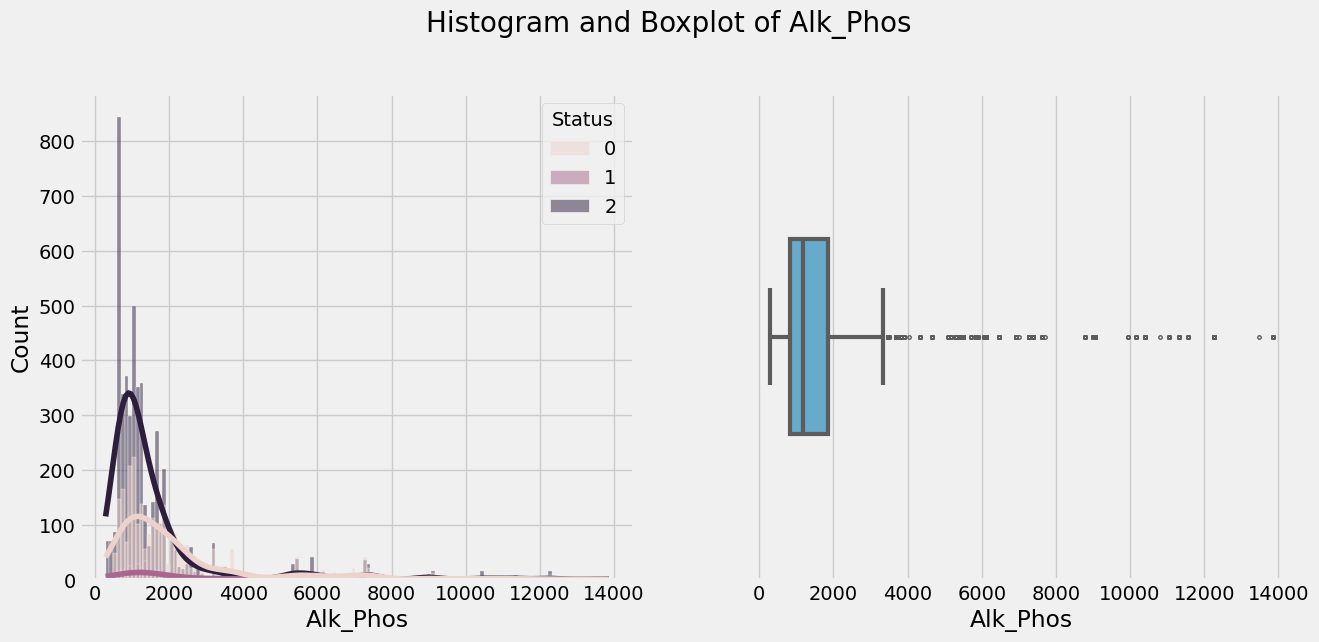

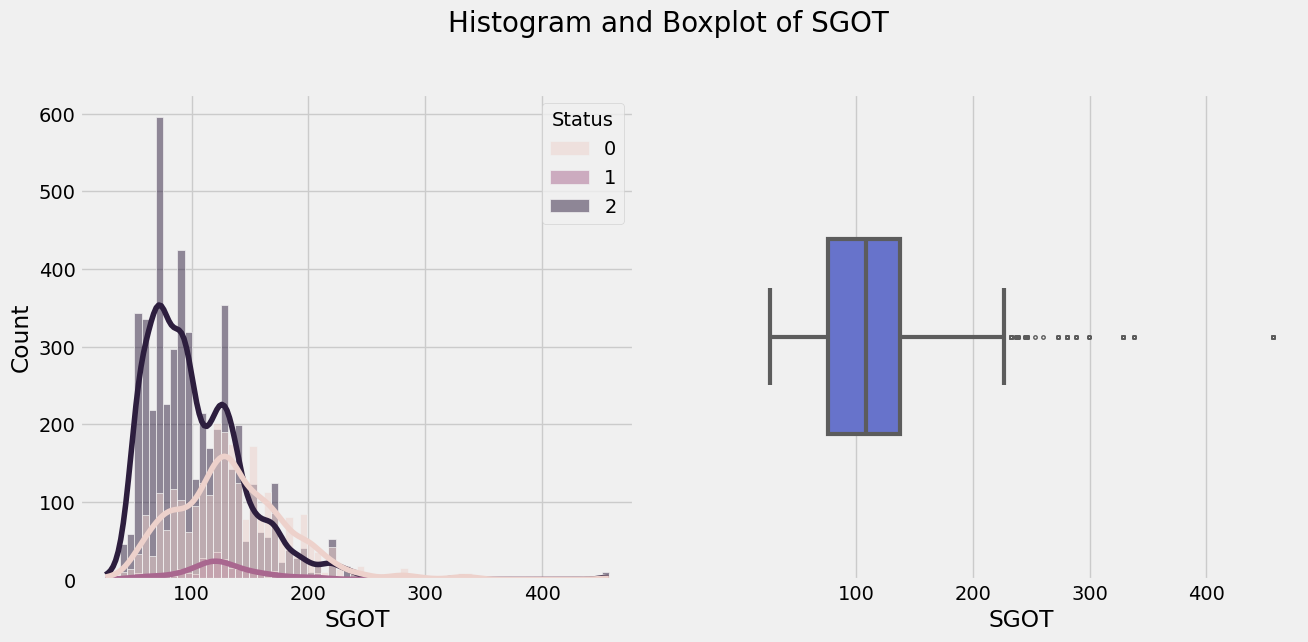

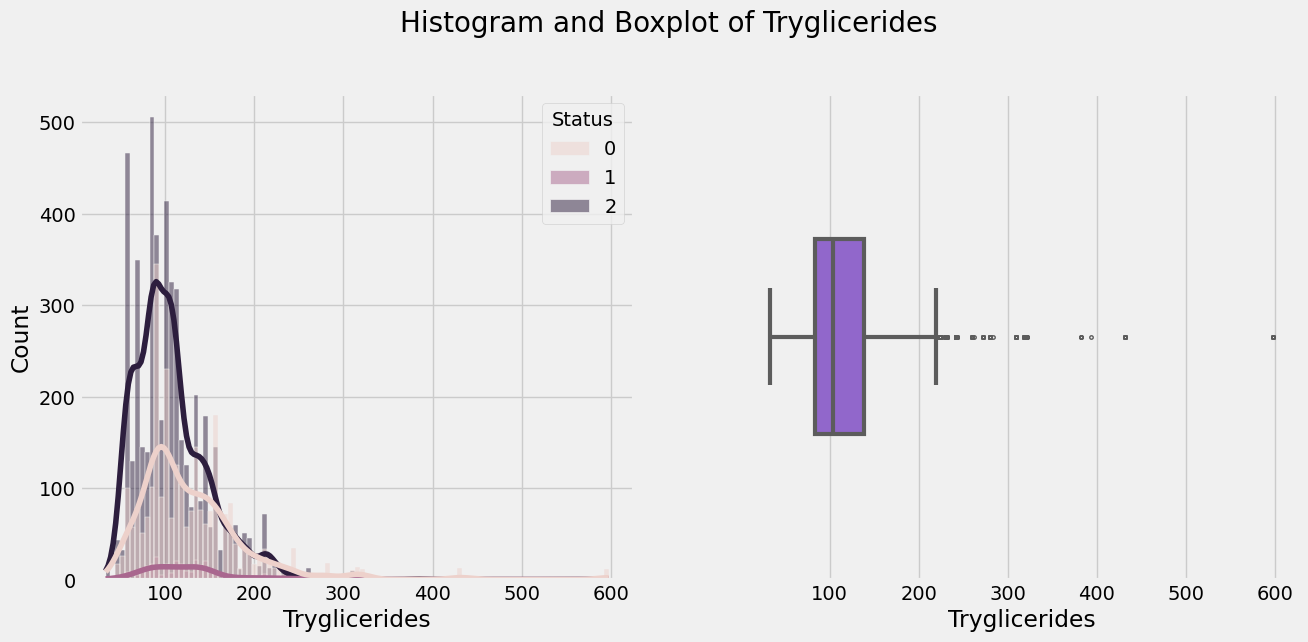

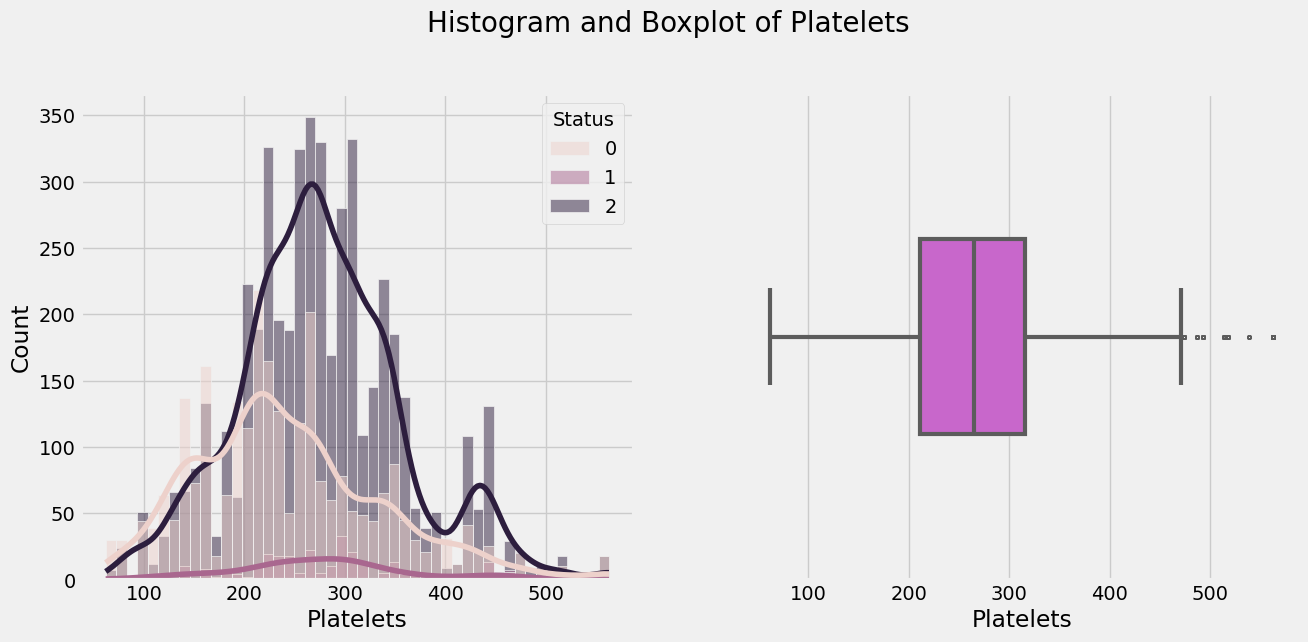

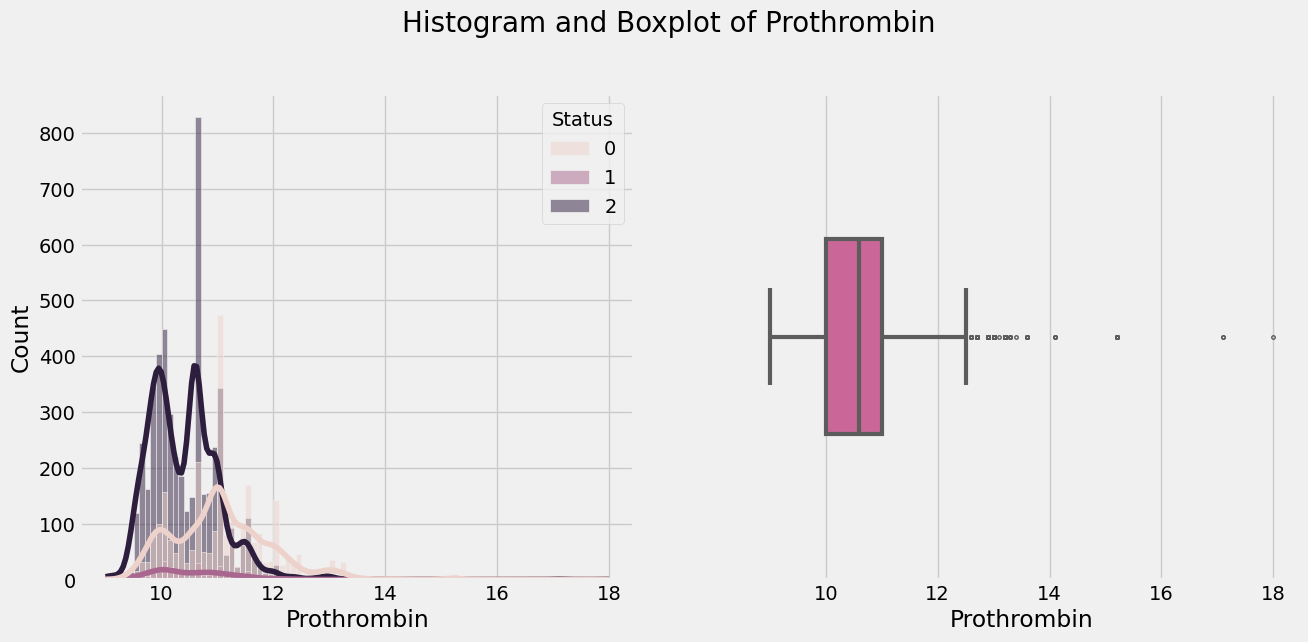

----------------------------------------------------------------------------------------------------
Countplot(s):



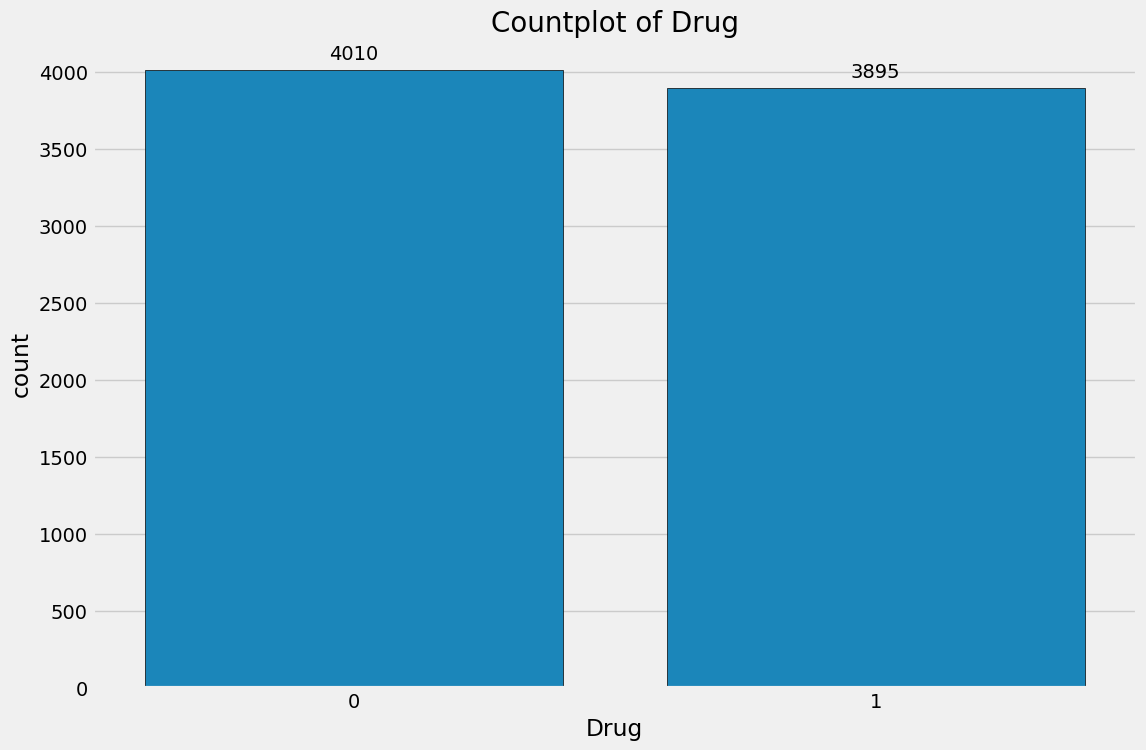

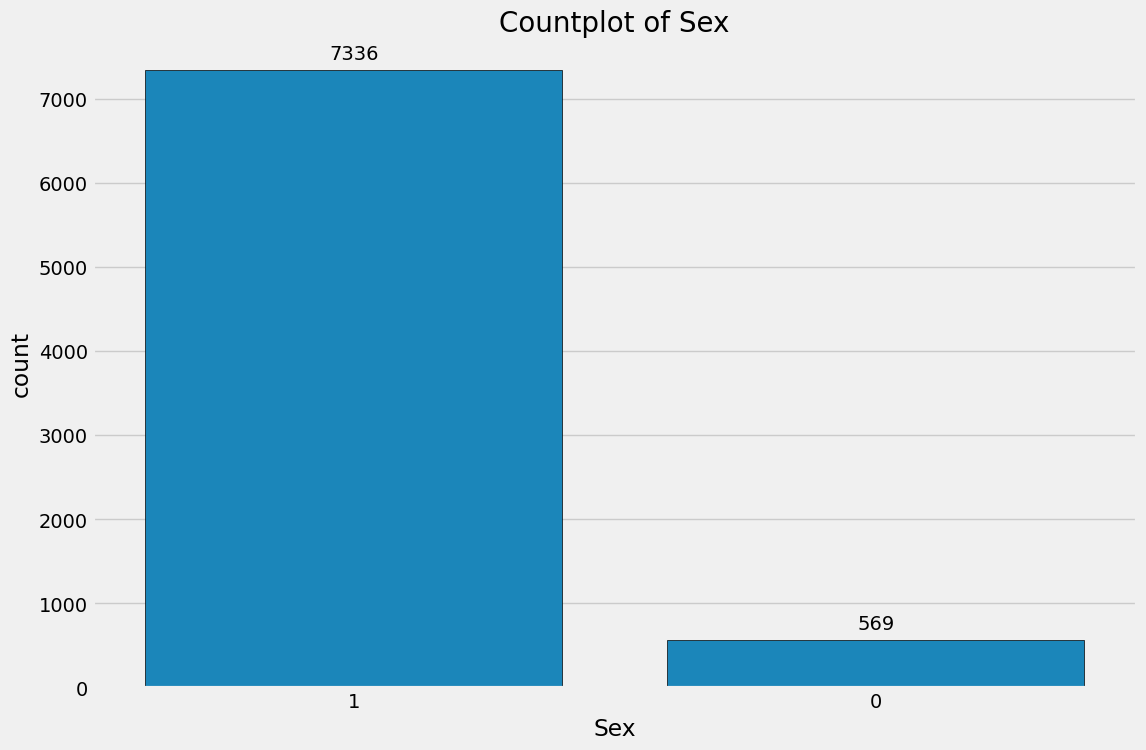

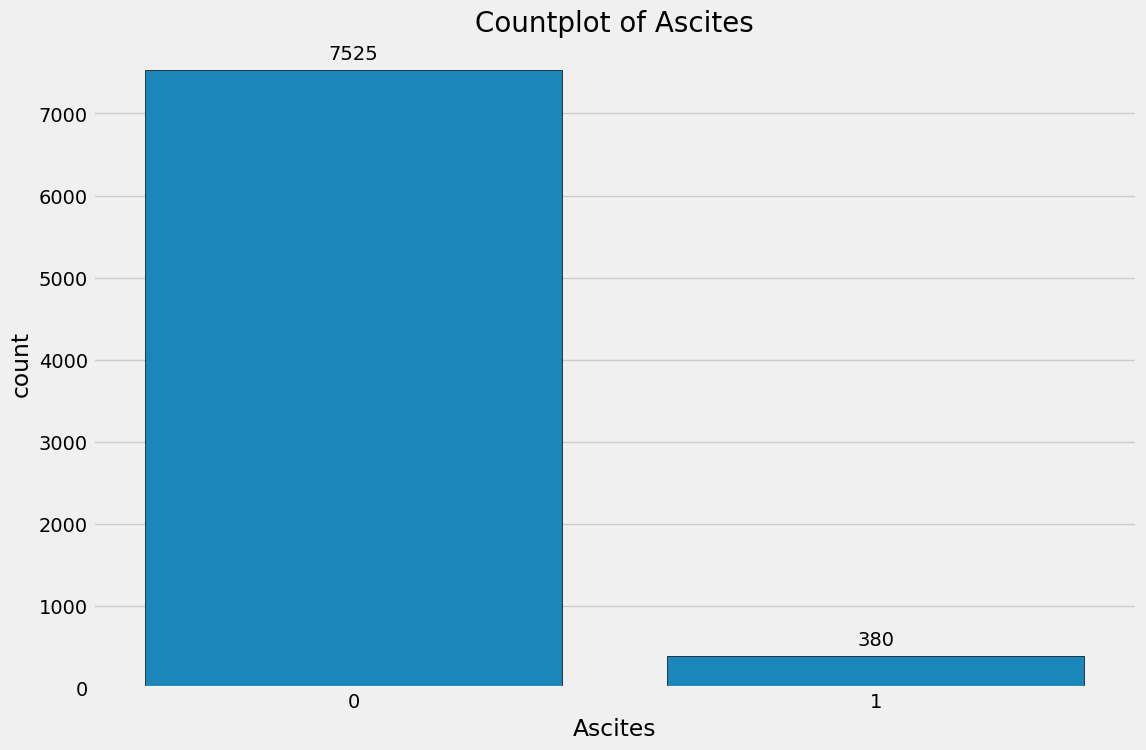

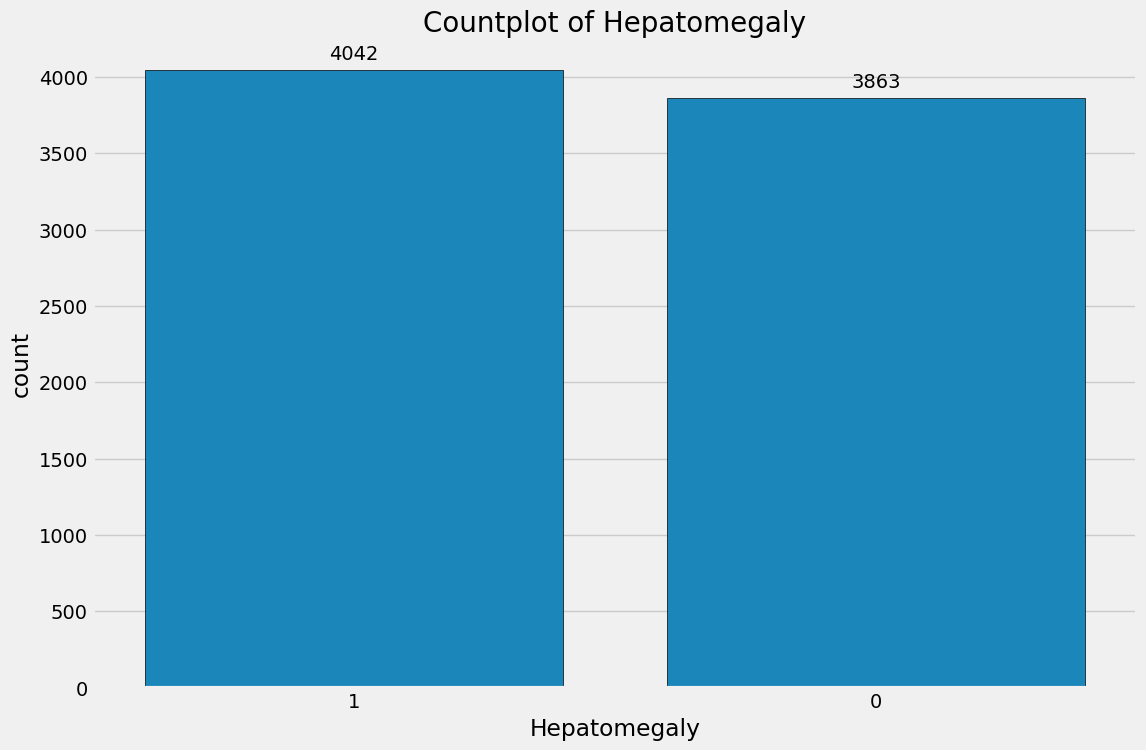

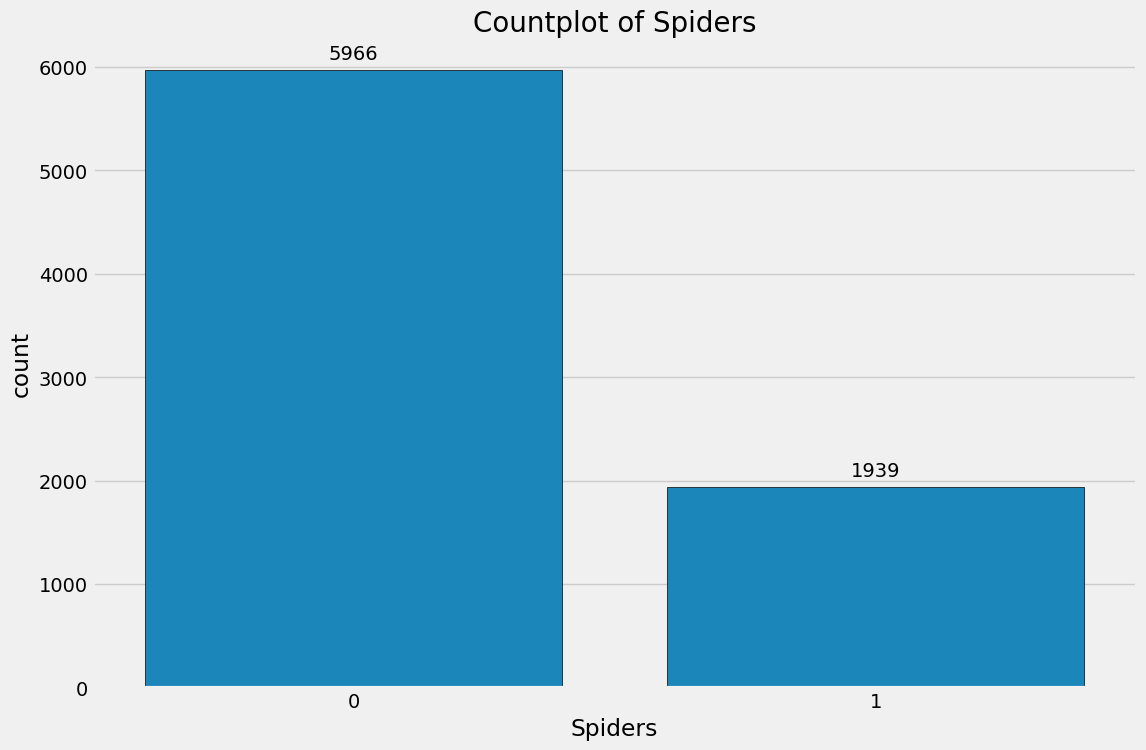

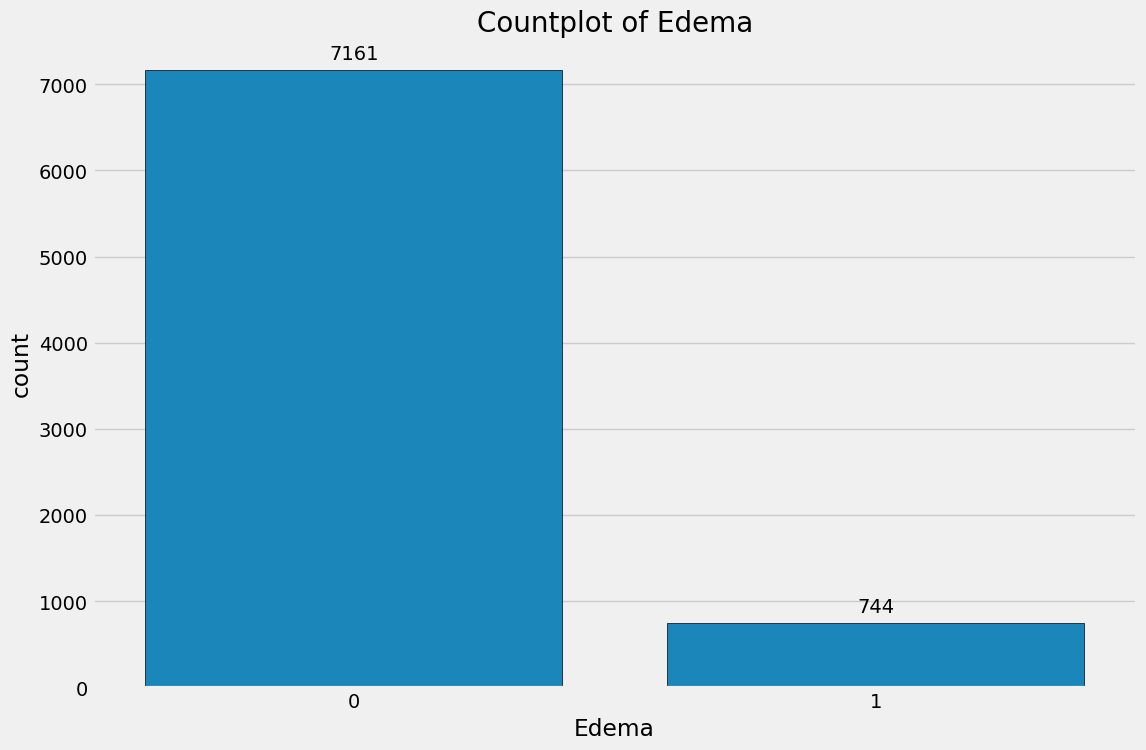

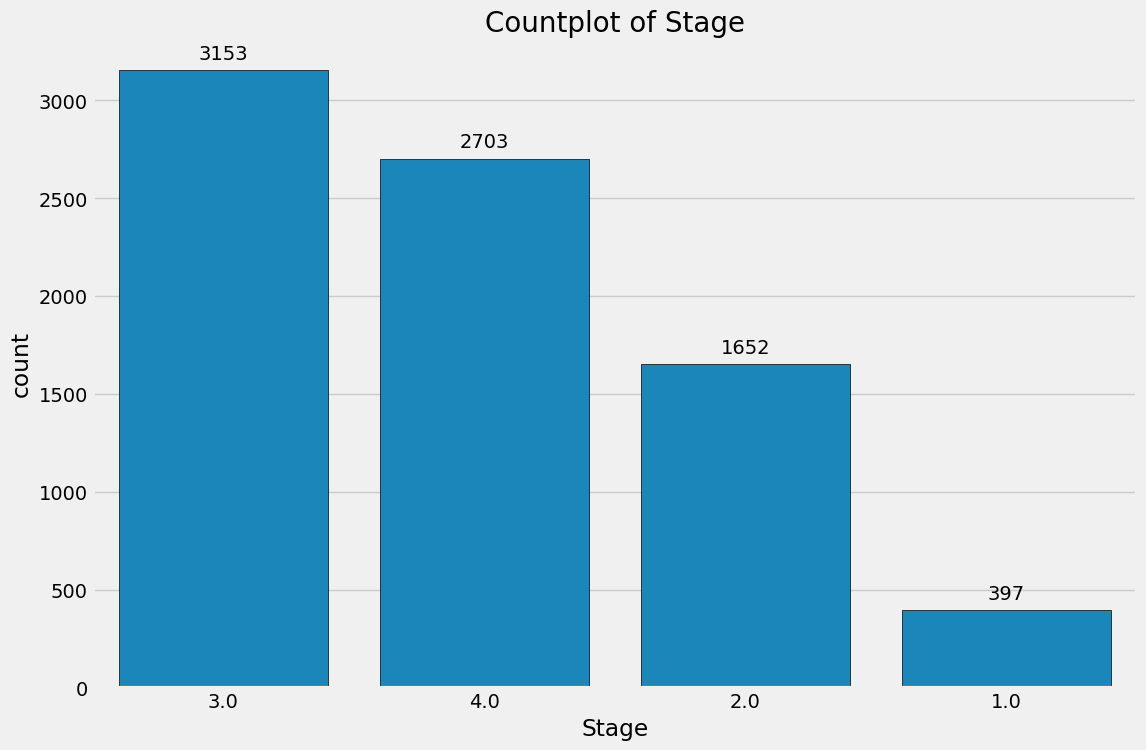

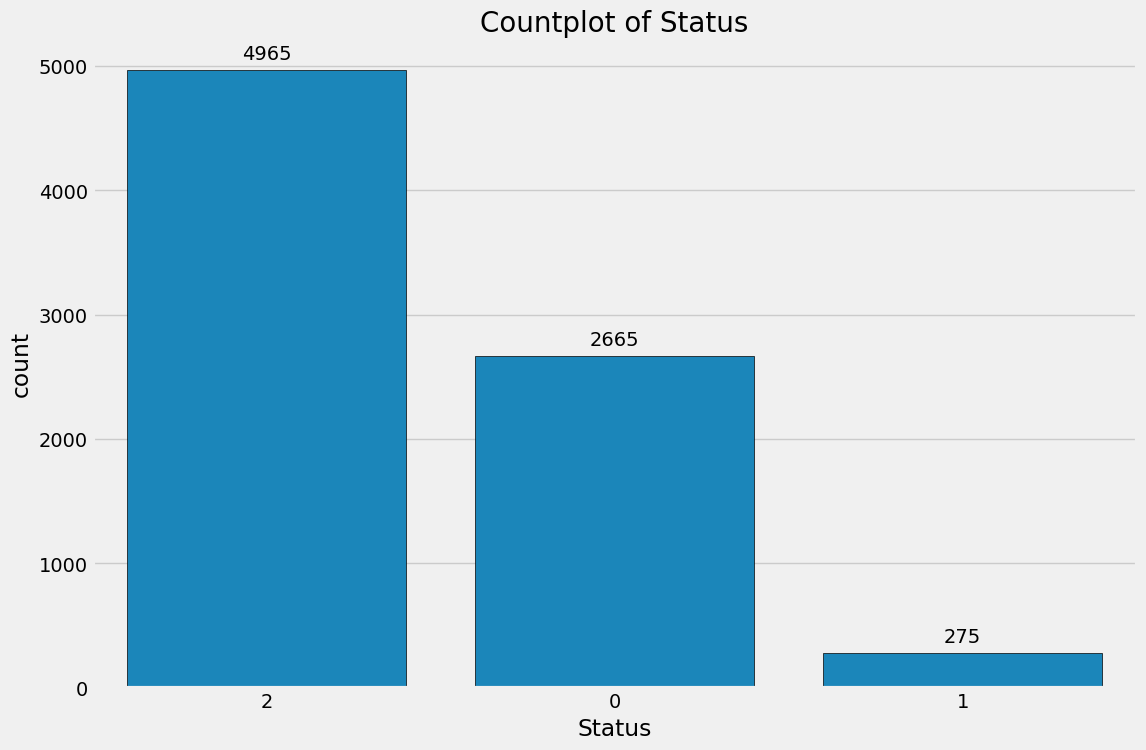

In [12]:
fast_eda(data_train, target = TARGET)

## Observations 

1. Some categorical feature columns are highly imbalanced for e.g Sex,Ascites
2. Some numerical feature are highly skewed and does not follow normal distribution 

# 4. Hyperparameter Tuning

In [13]:
# Hyperparameter tuning with Optuna

def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators',50,500),
        "max_depth":trial.suggest_int('max_depth',3,50),
        "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.25, log=True),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        "min_child_weight" : trial.suggest_float('min_child_weight', 0.5,4),
        "min_child_samples" : trial.suggest_int('min_child_samples',1,100),
        "subsample" : trial.suggest_float('subsample', 0.4, 1),
        "subsample_freq" : trial.suggest_int('subsample_freq',0,5),
        "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 64),
    }
    lgbmmodel_optuna = LGBMClassifier(**params, random_state=random_seed)
    cv = abs(cross_val_score(lgbmmodel_optuna, X, y, cv = 4,scoring='neg_log_loss').mean())
    return cv

In [14]:
## For Hyperparameter tuning LGBM/XGBoost Classifier 
# Takes a long time to execute
# X,y = data_train[FEATURES],data_train[TARGET]

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100, timeout=2000)

# 5. Model Training


In [15]:
def train_model(train_data, model, features, n_splits, kfold_seed, include_orig):
    
    model_name = str(model).split("(")[0]
    test_preds = np.zeros((len(data_test), 3))
    oof_full = np.zeros((len(train_data), 3))
    val_scores, models = [], []
    
    print(model_name)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_seed)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=kfold_seed)
    
    for i, (train_idx, val_idx) in enumerate(tqdm(skf.split(train_data[features], train_data[TARGET]))):

        X_train, X_val = train_data[features].loc[train_idx], train_data[features].loc[val_idx]
        y_train, y_val = train_data[TARGET].loc[train_idx], train_data[TARGET].loc[val_idx]

        # if it is true then add the miscellaneous data as present in competition page
        if include_orig:
            X_train = pd.concat([X_train, original[features]], ignore_index = True)
            y_train = pd.concat([y_train, original[TARGET]], ignore_index = True)
        
        if model_name == "LGBMClassifier":
            callbacks = [early_stopping(stopping_rounds=50)]
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=callbacks)
        elif model_name=="XGBClassifier":
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=10000)
        else:
            model.fit(X_train, y_train)
        
        oof_preds = model.predict_proba(X_val[features])
        test_preds += model.predict_proba(data_test[features]) / n_splits
 
        oof_full[val_idx] = oof_preds
        score = log_loss(y_val, oof_preds)
        
        models.append(model)
        val_scores.append(score)
            
        print(f"{i + 1}th FOLD Log_Loss: {np.round(score, 4)}")
        
    print(f'mean log_loss across all folds: {np.mean(val_scores):.5f}')
    print(f'std-dev of log_loss across all folds: {np.std(val_scores):.5f}')
    
    return oof_full, test_preds, models

## 5.1 XGBoost Classifier

In [16]:
# using the best params got by hyperparameter tuning
xgb_params = {
    'objective': 'multi_logloss', 
    'max_depth': 9, 
    'learning_rate': 0.034869481921747415, 
    'n_estimators': 10000,
    'early_stopping_rounds': 50,
    'min_child_weight': 9, 
    'colsample_bytree': 0.2, 
    'reg_alpha': 0.10626128775335533, 
    'reg_lambda': 0.624196407787772, 
    'random_state': random_seed
}

xgb_oof_preds, xgb_test_preds, xgb_models = train_model(
    train_data = data_train,
    model = XGBClassifier(**xgb_params),
    features = FEATURES,
    n_splits = 10,
    kfold_seed = 0,
    include_orig = True
)

XGBClassifier


0it [00:00, ?it/s]

[0]	validation_0-mlogloss:1.07541
[376]	validation_0-mlogloss:0.42044


1it [00:01,  1.61s/it]

1th FOLD Log_Loss: 0.4191
[0]	validation_0-mlogloss:1.07592
[369]	validation_0-mlogloss:0.43071


2it [00:02,  1.47s/it]

2th FOLD Log_Loss: 0.43
[0]	validation_0-mlogloss:1.07559
[336]	validation_0-mlogloss:0.42691


3it [00:04,  1.33s/it]

3th FOLD Log_Loss: 0.426
[0]	validation_0-mlogloss:1.07496
[430]	validation_0-mlogloss:0.40849


4it [00:05,  1.53s/it]

4th FOLD Log_Loss: 0.408
[0]	validation_0-mlogloss:1.07590
[419]	validation_0-mlogloss:0.41543


5it [00:07,  1.66s/it]

5th FOLD Log_Loss: 0.415
[0]	validation_0-mlogloss:1.07640
[357]	validation_0-mlogloss:0.43087


6it [00:09,  1.66s/it]

6th FOLD Log_Loss: 0.4303
[0]	validation_0-mlogloss:1.07498
[432]	validation_0-mlogloss:0.39453


7it [00:11,  1.84s/it]

7th FOLD Log_Loss: 0.3941
[0]	validation_0-mlogloss:1.07568
[412]	validation_0-mlogloss:0.42379


8it [00:13,  1.97s/it]

8th FOLD Log_Loss: 0.4219
[0]	validation_0-mlogloss:1.07626
[393]	validation_0-mlogloss:0.44372


9it [00:15,  1.79s/it]

9th FOLD Log_Loss: 0.4433
[0]	validation_0-mlogloss:1.07555
[352]	validation_0-mlogloss:0.41426


10it [00:16,  1.70s/it]

10th FOLD Log_Loss: 0.4135
mean log_loss across all folds: 0.42013
std-dev of log_loss across all folds: 0.01293


## 5.2 LGBM Boosting 

In [17]:
lgb_params = {
    'objective': 'multiclass', 
    'max_depth': 9, 
    'min_child_samples': 14, 
    'learning_rate': 0.034869481921747415, 
    'n_estimators': 100000, 
    'min_child_weight': 9, 
    'colsample_bytree': 0.1702910221565107, 
    'reg_alpha': 0.10626128775335533, 
    'reg_lambda': 0.624196407787772, 
    'random_state': random_seed
}

lgb_oof_preds, lgb_test_preds, lgb_models = train_model(
    train_data = data_train,
    model = LGBMClassifier(**lgb_params),
    features = FEATURES,
    n_splits = 10,
    kfold_seed = 0,
    include_orig = True
)


LGBMClassifier


0it [00:00, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1955
[LightGBM] [Info] Number of data points in the train set: 7532, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -1.079544
[LightGBM] [Info] Start training from score -3.321114
[LightGBM] [Info] Start training from score -0.471385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No 

1it [00:03,  3.39s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
1th FOLD Log_Loss: 0.4141
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1955
[LightGBM] [Info] Number of data points in the train set: 7532, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training fro

2it [00:07,  3.54s/it]

2th FOLD Log_Loss: 0.4272
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1957
[LightGBM] [Info] Number of data points in the train set: 7532, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -1.079544
[LightGBM] [Info] Start training from score -3.321114
[LightGBM] [Info] Start training from score -0.471385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 round

3it [00:10,  3.49s/it]

3th FOLD Log_Loss: 0.4249
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1957
[LightGBM] [Info] Number of data points in the train set: 7532, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -1.079544
[LightGBM] [Info] Start training from score -3.321114
[LightGBM] [Info] Start training from score -0.471385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 round

4it [00:14,  3.55s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
4th FOLD Log_Loss: 0.4064
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1958
[LightGBM] [Info] Number of data points in the train set: 7532, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -1.079544
[LightGBM] [Info] Start training from score -3.321114
[LightGBM] [Info] Start training from score -0.471385
[Lig

5it [00:17,  3.58s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
5th FOLD Log_Loss: 0.4154
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1959
[LightGBM] [Info] Number of data points in the train set: 7533, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -1.079286
[LightGBM] [Info] Start training from score -3.317577
[LightGBM] [Info] Start training from score -0.471731
[Lig

6it [00:21,  3.61s/it]

6th FOLD Log_Loss: 0.4307
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1955
[LightGBM] [Info] Number of data points in the train set: 7533, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -1.079286
[LightGBM] [Info] Start training from score -3.317577
[LightGBM] [Info] Start training from score -0.471731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 round

7it [00:25,  3.74s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
7th FOLD Log_Loss: 0.3982
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1958
[LightGBM] [Info] Number of data points in the train set: 7533, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training fro

8it [00:29,  3.73s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
8th FOLD Log_Loss: 0.4233
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1952
[LightGBM] [Info] Number of data points in the train set: 7533, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training fro

9it [00:32,  3.67s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[315]	valid_0's multi_logloss: 0.438093
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
9th FOLD Log_Loss: 0.4381
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_col_wise=true` to remove the ov

10it [00:36,  3.64s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[328]	valid_0's multi_logloss: 0.419374
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
10th FOLD Log_Loss: 0.4194
mean log_loss across all folds: 0.41978
std-dev of log_loss across all folds: 0.01116


# 6. Submissions File Preparation

In [18]:
sub = pd.DataFrame()

# giving equal weightage of both the models
# also tried submitting with individual predictions but giving equal importance resulted in slightly better score on leaderboard

sub[f"{TARGET}_D"] =  xgb_test_preds[:, 0] * 0.5 + lgb_test_preds[:, 0] * 0.5
sub[f"{TARGET}_CL"] = xgb_test_preds[:, 1] * 0.5 + lgb_test_preds[:, 1] * 0.5
sub[f"{TARGET}_C"] =  xgb_test_preds[:, 2] * 0.5 + lgb_test_preds[:, 2] * 0.5
sub.head(3)


,Status_D,Status_CL,Status_C
0,0.564714,0.038401,0.396885
1,0.275861,0.220435,0.503704
2,0.953160,0.010447,0.036393


In [19]:
sub.to_csv("submission_lgbm+xgboost.csv", index = False)